# 0.Assignments

👾 這個陽春的聊天機器人需要被優化！<br>
若是一個對話串不間斷地持續進行，送進去的訊息量會很多，tokens數量也會跟著增加，會需要花比較多費用(💸💸💸)，也可能使模型的回應雜訊比較多而回應受到干擾，所以我們可以優化短期記憶。<br>
另外，我們希望優化使用者體驗，我們可以根據聊天的內容整理出使用者的屬性，並在每一次跟使用者聊天時，都能根據這個使用者的狀況給予客製化的回應，因此我們要加入長期記憶的功能！

<br>

### 1. 短期記憶優化

(1) 🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)


<br>

### 2. 加入長期記憶

加入長期記憶，讓聊天機器人能夠記住使用者的資訊（名字、偏好語言、興趣），在下一次對話也能針對同個使用者的資訊，給予個人化的回答。

(1) 🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>


(2) 👨‍🎓 [進階版]
- chatbot node: 可以決定使用者的問題是否需要從長期記憶中取得資訊，以及需要取得什麼資訊
- write_memory node: 可以整理成特定格式 (例如：使用with_structured_output，相關概念可以延伸到R3 tool calling內容)。例如：
```
user_profile = {
  "first_name": "XXXX",
  "last_name": "OOO",
  "preferred_lang": ["en", "zh-tw"]
}
```
- 也可以自行將graph結構調整自己喜歡的(增刪不同node, conditional router, ...)
<br>
備註：基本版是需要大家完成的，進階版可以自行決定是否挑戰，Enjoy the ride! 😎

# 1.短期記憶

## (1) 基本版
🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)

note: 可以邊做邊看一下trim設定的效果以及內部運作的機制

In [1]:
%%capture --no-stderr
!pip install -U langgraph langchain_openai==0.3.15 langchain transformers bitsandbytes langchain-huggingface

In [36]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from langchain_huggingface import HuggingFacePipeline

# 會需要一點時間
# 使用 4-bit 量化模型
model_id = "MediaTek-Research/Breeze-7B-Instruct-v1_0"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_threshold=6.0,
)

# 載入 tokenizer 與 4-bit 模型
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quant_config,
    trust_remote_code=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/911k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.79M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.60G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/508M [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [37]:
generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.4,
    return_full_text=False # 僅返回生成的回應內容
)

# 包裝成 LangChain 的 llm 物件
llm = HuggingFacePipeline(pipeline=generator)

Device set to use cuda:0


In [2]:
!pip install langchain-community langchain-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00


In [3]:
import os
from langchain.chat_models import AzureChatOpenAI
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

# 課金openai
llm_azure = AzureChatOpenAI(
    openai_api_base="https://intern-bryan.cognitiveservices.azure.com/",
    openai_api_version="2024-08-01-preview",
    deployment_name="gpt-4o",
    openai_api_key="AwKyfa7qPtoM0f9tnZksQSlVKobqzrwVI56Fmbqpv0tU07MM2WV8JQQJ99AKACYeBjFXJ3w3AAAAACOG55vD",
    temperature=0.3,
)

# 呼叫huggingface上的API模型 (free)
llm_endpoint = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen2.5-32B-Instruct",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)

llm_huggingface = ChatHuggingFace(llm=llm_endpoint, verbose=False)

<ipython-input-3-596681d24297>:6: LangChainDeprecationWarning: The class `AzureChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import AzureChatOpenAI``.
  llm_azure = AzureChatOpenAI(
/usr/local/lib/python3.11/dist-packages/langchain_community/chat_models/azure_openai.py:174: UserWarning: As of openai>=1.0.0, Azure endpoints should be specified via the `azure_endpoint` param not `openai_api_base` (or alias `base_url`). Updating `openai_api_base` from https://intern-bryan.cognitiveservices.azure.com/ to https://intern-bryan.cognitiveservices.azure.com/openai.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/langchain_community/chat_models/azure_openai.py:181: UserWarning: As of openai>=1.0.0, if `deployment_name` (or alias `azure_deployment`) is

In [4]:
# LLM選擇器
llm_selector = {
    "azure_openai": llm_azure,
    "huggingface_qwen": llm_huggingface,}

# 預設使用哪個模型
llm_api = llm_selector["azure_openai"]

In [38]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage,  SystemMessage

from transformers import AutoTokenizer
from langgraph.checkpoint.memory import MemorySaver

from functools import partial

class State(TypedDict):
  messages: Annotated[list, add_messages]

# 自己寫 token count function
def count_tokens_approximately(messages):
    text = "\n".join([msg.content for msg in messages])
    return len(tokenizer.encode(text))

# 自己寫 trim function (簡單暴力版)
def trim_messages(messages, max_tokens):
    while count_tokens_approximately(messages) > max_tokens and len(messages) > 1:
        messages = messages[1:]  # 移除最舊的一筆
    return messages

def chatbot(state: State, llm_api):
  # 💻code below:
  # hint: you can use langchain_core trim_messages function to trim your trim_messages, and count_tokens_approximately to count tokens
    # 設定系統提示
    system_prompt = "你是個只能使用繁體中文回答的助理"
    system_message = SystemMessage(content=system_prompt)

    messages = state["messages"]                               # 取得目前的訊息
    full_messages = [system_message] + messages                # 先把系統訊息加進來
    max_tokens = 3000                                          # 設定token上限（例如：總共最多 3000 tokens）
    full_messages = trim_messages(full_messages, max_tokens)   # 裁切訊息
    response = llm_api.invoke(full_messages)                   # 呼叫llm
    return {"messages": [response]}

# 建立graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", partial(chatbot, llm_api=llm_api)) # 在graph裡面加入chatbot的node
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 加入短期記憶
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


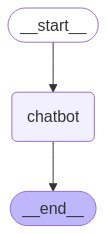

In [39]:
# 看一下graph
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [40]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
      if "chatbot" in event:
        for value in event.values():
          print("Assistant:", value["messages"][-1].content)

In [41]:
# 設定對話config (第一次對話)
config = {"configurable": {"thread_id": "conversation_1"}} # thread_id: 對話id

In [42]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

User: 嗨 我是火影忍者迷
Assistant: 嗨！很高興認識你。火影忍者是一部非常受歡迎的動漫，充滿了精彩的故事和深刻的人物刻畫。你最喜歡的角色或劇情是哪一部分呢？
User: 我喜歡宇智波佐助
Assistant: 宇智波佐助是一個非常受歡迎且複雜的角色。他的成長過程充滿了挑戰和內心的掙扎，從他對復仇的執著到最終尋找自己的道路。佐助的故事涉及家庭、忠誠和自我認識，這些元素使他成為一個引人入勝的角色。你喜歡佐助的哪個方面或故事情節呢？
User: 我們來聊點別的
Assistant: 好的！你想聊什麼話題呢？無論是其他動漫、電影、音樂，還是生活中的事情，我都很樂意和你交流。
User: 那你還記得我喜歡甚麼嗎
Assistant: 當然記得！你提到過你是火影忍者迷，並且特別喜歡宇智波佐助。如果有其他你感興趣的話題或想聊的內容，隨時告訴我哦！
User: q
Goodbye!


---

# 2.長期記憶

## (1) 基本版
🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>

In [43]:
%%capture --no-stderr
!pip install langchain_core

In [93]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver # within-thread memory
from langgraph.store.memory import InMemoryStore # cross-thread store

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage


class State(TypedDict):
  messages: Annotated[list, add_messages]

store = InMemoryStore()

def chatbot(state: State, config: dict):
  # 💻code here:
  # TODO:
  # 依據user_id取得長期記憶
  # 將長期記憶也放進system prompt中，讓llm可以個人化回覆
  user_id = config["configurable"]["user_id"]

  # 從長期記憶store讀取使用者資訊
  user_profile = store.get(key=user_id, namespace=None) or "尚未有使用者資訊。"

  system_prompt = f"""你是個只能使用繁體中文回答的助理。
  以下是已知的使用者資訊，請根據這些資訊提供個人化回應：
  使用者資訊: {user_profile}
  """

  system_message = SystemMessage(content=system_prompt)
  messages = state["messages"]
  full_messages = [system_message] + messages

  # 呼叫llm
  response = llm_api.invoke(full_messages)
  return {"messages": [response]}
  #return {"messages": [AIMessage(content=response)]}


def write_memory(state: State, config: dict):
  # 💻code here:
  # TODO:
  # 將使用者的對話整理成要儲存成長期記憶的資訊，並存入長期記憶
  user_id = config["configurable"]["user_id"]
  messages = state["messages"]

  # 取出近期對話
  recent_dialogue = "\n".join([f"{m.type}: {m.content}" for m in messages[-5:]])

  # 用LLM摘要使用者資訊
  system_prompt = """你是一個負責整理使用者資訊的系統，請依據對話紀錄整理使用者的個人資訊，包含：
  -興趣嗜好
  -性格特徵
  -需求與問題
  -其他有幫助的資訊
  請簡潔整理成一段使用者描述 (限100字內)。
  """

  llm_input = [SystemMessage(content=system_prompt), HumanMessage(content=recent_dialogue)]

  profile_summary = llm_api.invoke(llm_input)
  # 更新長期記憶
  store.set(key=user_id, value=profile_summary, namespace=None)
  return state

# Define the graph
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", "write_memory")
builder.add_edge("write_memory", END)


# Compile the graph with the checkpointer fir and store

# 💻Code Here
# 記得放入短期記憶，長期記憶的store
# 短期記憶 + 長期記憶
memory = MemorySaver()
graph = builder.compile(checkpointer=memory, store=store)


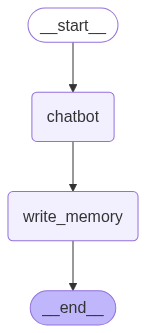

In [94]:
# View
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [95]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        if "chatbot" in event:
          for value in event.values():
              print("Assistant:", value["messages"][-1].content)

In [96]:
# 使用者A的第一次對話
config = {"configurable": {"thread_id": "conversation_1", "user_id": "user_a"}}

In [97]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

User: 嗨 我是火影忍者迷


/usr/local/lib/python3.11/dist-packages/langgraph/utils/runnable.py:377: RuntimeWarning: coroutine 'BaseStore.aget' was never awaited
  ret = self.func(*args, **kwargs)


Assistant: 嗨！很高興認識你，火影忍者是一部非常受歡迎的動漫。你最喜歡的角色或場景是什麼呢？或者有什麼特別的情節讓你印象深刻嗎？我們可以一起聊聊！
'InMemoryStore' object has no attribute 'aset'


In [98]:
# 使用者A的第二次對話
config = {"configurable": {"thread_id": "conversation_2", "user_id": "user_a"}}

In [99]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

User: 嗨 我是火影忍者迷


/usr/local/lib/python3.11/dist-packages/langgraph/utils/runnable.py:377: RuntimeWarning: coroutine 'BaseStore.aget' was never awaited
  ret = self.func(*args, **kwargs)


Assistant: 嗨！太棒了！火影忍者是一部非常受歡迎的動漫，充滿了精彩的故事和令人難忘的角色。你最喜歡的角色或情節是什麼呢？我們可以聊聊這部作品！
'InMemoryStore' object has no attribute 'aset'


## (2) 進階版

👨‍🎓 [進階版]
- chatbot node: 可以決定使用者的問題是否需要從長期記憶中取得資訊，以及需要取得什麼資訊
- write_memory node: 可以整理成特定格式 (例如：使用with_structured_output，相關概念可以延伸到R3 tool calling內容)。例如：
```
user_profile = {
  "first_name": "XXXX",
  "last_name": "OOO",
  "preferred_lang": ["en", "zh-tw"]
}
```
- 也可以自行將graph結構調整自己喜歡的(增刪不同node, conditional router, ...)

In [ ]:
# 💻code here, enjoy the ride 😎
